In [3]:
from IPython.display import HTML
import time

handle = display(HTML("""<marquee>👌</marquee>"""), display_id='html_marquee1')
time.sleep(2)
handle = display(HTML("""<marquee>~ “A satisfied customer is the best business strategy of all.” – Michael LeBoeuf</marquee>"""), display_id='html_marquee1', update=True)

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Overview</div>

In this notebook, we are going to apply advanced topic modeling techniques with [BERTopic](https://github.com/MaartenGr/BERTopic) to Airline Reviews. 

Topic modeling is a technique that allows users to generate insights into large amount of textual data without the need to read them individually.

However, the real power of topic modeling is looking beyond merely generating topics and using them to truly understand the relationships and patterns in the data.

<div class="alert alert-block alert-info"> ✅ <b>Note</b>: <i>BERTopic</i> is an open-source library developed and maintained by <a href="https://www.kaggle.com/maartengr" target="_blank">Maarten Grootendorst</a>. You can learn more about <i>BERTopic</i> in its <a href="https://maartengr.github.io/BERTopic/index.html" target="_blank">product documentation</a>.
</div>

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Executive Summary</div>

TBD

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Preparations</div>

We start by installing BERTopic from PyPi

In [4]:
%%capture
!pip install bertopic

After we are done with *BERTopic* installation, we will import all necessary packages.

In [5]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True) 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Data Retrieval and Preprocessing</div>

First of all, we will read the airlines review dataset in memory

In [6]:
run_locally = False
if run_locally:
    dataset_path = './Airline_review.csv'
else:
    dataset_path = '../input/airline-reviews/Airline_review.csv'
    
df = pd.read_csv(dataset_path, index_col=0)
df.head()

,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,November 2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,June 2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,June 2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,September 2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


<div class="alert alert-block alert-info"> ✅ <b>Note</b>: You may want to refer to the detailed EDA and sentiment analysis of the airline reviews as per another notebook I collated: <a href="https://www.kaggle.com/code/gvyshnya/airline-reviews-sentiments-ts-and-eda/" target="_blank">Airline Reviews: Sentiments, TS, and EDA</a>.
</div>

After we read the data in memory, we are going to do some basic feature engineering and data preprocessing needed in our topic modelling efforts down the road

- basic NLP transformation of the review text (such a preprocessing will involve the common steps like casting everything to the lower case, removing stop words, lemmatizing the tokens etc.), using NLTK
- extracting review date as a new datetime feature (to enable time-based topic modelling down the road)

In [7]:
df['review_datetime'] = pd.to_datetime(df['Review Date'])

In [8]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# download nltk corpus (first time only)
nltk.download([
"names",
"stopwords",
"vader_lexicon",
"punkt",
"wordnet"
])

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



[nltk_data] Downloading package names to /usr/share/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [10]:
# create preprocess_text function
def preprocess_text(text):

    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]


    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

start_time = dt.datetime.now()
print("Started text preprocessing at ", start_time)
df['Review'] = df['Review'].apply(preprocess_text)
end_time = dt.datetime.now()
elapsed_time = end_time - start_time
print("Finished text preprocessing at ", end_time)
print ("Text preprocessing completed. Elapsed time: ", elapsed_time)

Started text preprocessing at  2023-08-30 19:59:32.329982
Finished text preprocessing at  2023-08-30 20:07:38.850364
Text preprocessing completed. Elapsed time:  0:08:06.520382


# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Training the Topic Model</div>

Next, we train our BERTopic model using just a few changes to the default BERTopic parameters.

First of all, we choose a pre-trained embedding model. The string **"paraphrase-MiniLM-L6-v2"** references the embedding model that can be found [here](https://www.sbert.net/docs/pretrained_models.html#sentence-embedding-models). It is a great sentence-transformer model that balances performance with speed.

Then, we make sure that the minimum topic size of our topics is *50* documents (reviews). We do this to limit the number of topics that could be generated. For example, if the minimum were to be 10 then much more topics could be generated. Such topics would most likely be of little interest. Since we want large topics, we set it to 50.

In [11]:
from bertopic import BERTopic

start_time = dt.datetime.now()

docs = df['Review']

topic_model = BERTopic(verbose=True, embedding_model="paraphrase-MiniLM-L12-v2", min_topic_size=50)
topics, _ = topic_model.fit_transform(docs); len(topic_model.get_topic_info())
end_time = dt.datetime.now()
elapsed_time = end_time - start_time

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to th

Batches:   0%|          | 0/725 [00:00<?, ?it/s]

2023-08-30 20:09:17,131 - BERTopic - Transformed documents to Embeddings
2023-08-30 20:10:01,935 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
print("Started topic modelling at ", start_time)
print("Finished topic modelling at ", end_time)
print ("Topic modelling completed. Elapsed time: ", elapsed_time)

Started topic modelling at  2023-08-30 20:08:11.331905
Finished topic modelling at  2023-08-30 20:10:11.188945
Topic modelling completed. Elapsed time:  0:01:59.857040


<div class="alert alert-block alert-info"> ✅ <b>Note</b>:  BERTopic is stochastic since it uses UMAP as one of its dependencies so the results may differ between runs.</div>

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Topic Representation</div>

We can see that roughly 40+ topics were generated from the corpus of airline reviews. Let's review them in the table below

In [13]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,8351,-1_flight_seat_airline_time,"[flight, seat, airline, time, service, hour, w...",[brussels cancun jetairfly . booked 4 day flig...
1,0,3716,0_flight_airline_customer_hour,"[flight, airline, customer, hour, worst, get, ...","[first , paid first class ticket ! lot money !..."
2,1,932,1_sydney_qantas_melbourne_flight,"[sydney, qantas, melbourne, flight, brisbane, ...",[los angeles auckland via papeete . dec 21 not...
3,2,825,2_good_crew_friendly_cabin,"[good, crew, friendly, cabin, service, food, f...",[enjoyable flight . easy friendly check . plan...
4,3,733,3_johannesburg_cape_town_flight,"[johannesburg, cape, town, flight, nairobi, ti...",[harare cape town via johannesburg . flight ha...
5,4,726,4_dubai_kuwait_flight_qatar,"[dubai, kuwait, flight, qatar, hour, doha, tim...",[dubai kuwait . excellent service kuwait airwa...
6,5,663,5_gatwick_cook_thomas_manchester,"[gatwick, cook, thomas, manchester, flight, se...",[manchester ft lauderdale via new york jfk . b...
7,6,644,6_toronto_canada_flight_air,"[toronto, canada, flight, air, hour, swoop, ly...",[fly airline . know airline perfect ton thing ...
8,7,628,7_bangkok_thai_nok_phuket,"[bangkok, thai, nok, phuket, flight, check, ai...",[contact phone rebooking ; email ( uk ) -- don...
9,8,624,8_china_shanghai_beijing_xiamen,"[china, shanghai, beijing, xiamen, chinese, ai...",[hong kong shanghai business class . flight cr...


<div class="alert alert-block alert-info"> ✅ <b>Note</b>: The -1 topic refers to all outlier documents and are typically ignored.</div>
    
Each word in a topic describes the underlying theme of that topic and can be used for interpreting that topic. 

Let's take a look at the most frequent topic that was generated:

In [14]:
topic_model.get_topic(0)

[('flight', 0.01719325113480973),
 ('airline', 0.015559269147824982),
 ('customer', 0.014834512284733526),
 ('hour', 0.01374232654601149),
 ('worst', 0.01318184440175137),
 ('get', 0.012619554725245048),
 ('never', 0.01227199015137891),
 ('time', 0.012220292909752824),
 ('refund', 0.011912288223209746),
 ('service', 0.011507040058039692)]

Now, let's look at how the original airline reviews have been mapped to the topics identified.

In [15]:
df_docs = topic_model.get_document_info(docs)
df_docs.head(10)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,moroni moheli . turned pretty decent airline ....,2,2_good_crew_friendly_cabin,"[good, crew, friendly, cabin, service, food, f...",[enjoyable flight . easy friendly check . plan...,good - crew - friendly - cabin - service - foo...,0.910678,False
1,moroni anjouan . small airline . ticket advise...,-1,-1_flight_seat_airline_time,"[flight, seat, airline, time, service, hour, w...",[brussels cancun jetairfly . booked 4 day flig...,flight - seat - airline - time - service - hou...,0.000000,False
2,anjouan dzaoudzi . small airline airline based...,-1,-1_flight_seat_airline_time,"[flight, seat, airline, time, service, hour, w...",[brussels cancun jetairfly . booked 4 day flig...,flight - seat - airline - time - service - hou...,0.000000,False
3,please favor fly adria . route munich pristina...,9,9_berlin_lufthansa_germanwings_flight,"[berlin, lufthansa, germanwings, flight, lugga...",[due fly london heathrow berlin tegel 20 july ...,berlin - lufthansa - germanwings - flight - lu...,0.720295,False
4,book flight airline ! friend returned sofia am...,-1,-1_flight_seat_airline_time,"[flight, seat, airline, time, service, hour, w...",[brussels cancun jetairfly . booked 4 day flig...,flight - seat - airline - time - service - hou...,0.000000,False
5,bad experience rerouted cancelled flight last ...,14,14_prague_czech_serbia_smartwings,"[prague, czech, serbia, smartwings, csa, belgr...",[purchased roundtrip ticket beirut prague . fi...,prague - czech - serbia - smartwings - csa - b...,0.508158,False
6,"ljubljana zürich . firstly , ljubljana airport...",-1,-1_flight_seat_airline_time,"[flight, seat, airline, time, service, hour, w...",[brussels cancun jetairfly . booked 4 day flig...,flight - seat - airline - time - service - hou...,0.000000,False
7,"first , complaining specific flight . lufthans...",9,9_berlin_lufthansa_germanwings_flight,"[berlin, lufthansa, germanwings, flight, lugga...",[due fly london heathrow berlin tegel 20 july ...,berlin - lufthansa - germanwings - flight - lu...,0.992024,False
8,worst airline ever ! combined two flight save ...,0,0_flight_airline_customer_hour,"[flight, airline, customer, hour, worst, get, ...","[first , paid first class ticket ! lot money !...",flight - airline - customer - hour - worst - g...,1.000000,False
9,ljubljana munich . homebase airport adria airw...,-1,-1_flight_seat_airline_time,"[flight, seat, airline, time, service, hour, w...",[brussels cancun jetairfly . booked 4 day flig...,flight - seat - airline - time - service - hou...,0.000000,False


Now, let's review the summary statistics on the review distribution by the topics identified.

In [16]:
freq = topic_model.get_topic_info()
freq.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,8351,-1_flight_seat_airline_time,"[flight, seat, airline, time, service, hour, w...",[brussels cancun jetairfly . booked 4 day flig...
1,0,3716,0_flight_airline_customer_hour,"[flight, airline, customer, hour, worst, get, ...","[first , paid first class ticket ! lot money !..."
2,1,932,1_sydney_qantas_melbourne_flight,"[sydney, qantas, melbourne, flight, brisbane, ...",[los angeles auckland via papeete . dec 21 not...
3,2,825,2_good_crew_friendly_cabin,"[good, crew, friendly, cabin, service, food, f...",[enjoyable flight . easy friendly check . plan...
4,3,733,3_johannesburg_cape_town_flight,"[johannesburg, cape, town, flight, nairobi, ti...",[harare cape town via johannesburg . flight ha...
5,4,726,4_dubai_kuwait_flight_qatar,"[dubai, kuwait, flight, qatar, hour, doha, tim...",[dubai kuwait . excellent service kuwait airwa...
6,5,663,5_gatwick_cook_thomas_manchester,"[gatwick, cook, thomas, manchester, flight, se...",[manchester ft lauderdale via new york jfk . b...
7,6,644,6_toronto_canada_flight_air,"[toronto, canada, flight, air, hour, swoop, ly...",[fly airline . know airline perfect ton thing ...
8,7,628,7_bangkok_thai_nok_phuket,"[bangkok, thai, nok, phuket, flight, check, ai...",[contact phone rebooking ; email ( uk ) -- don...
9,8,624,8_china_shanghai_beijing_xiamen,"[china, shanghai, beijing, xiamen, chinese, ai...",[hong kong shanghai business class . flight cr...


We can see that a significant fraction of the reviews is considered to be outliers, and therefore they are mapped to the catch-all 'other' topic bucket (with *Topic = -1*).

Let's visualize the review counts by the identified topics, the catch-all 'other' one exclusive.

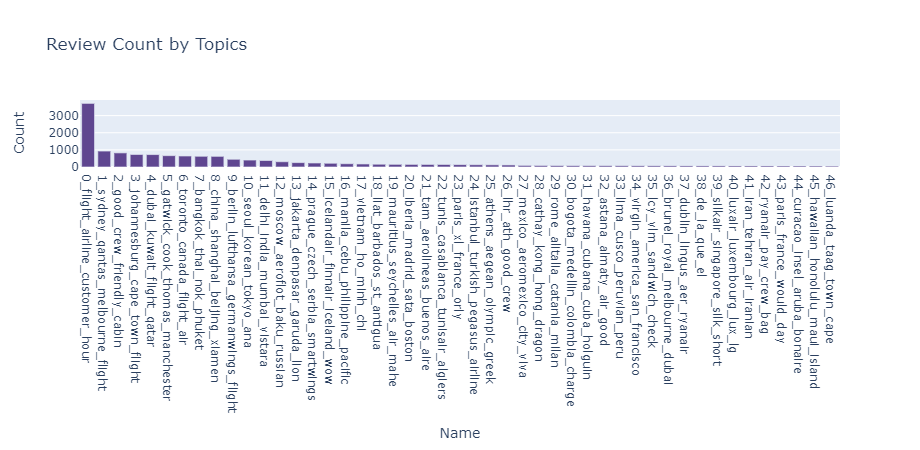

In [17]:
topic_freq = freq[freq['Topic'] > -1]
fig = px.bar(topic_freq, x='Name', y='Count', 
             title='Review Count by Topics',
            color_discrete_sequence=px.colors.qualitative.Prism) 
fig.show()

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Topic Words</div>

Let's visualize the most frequent terms (words) occured in the airline reviews of the top topics discovered.

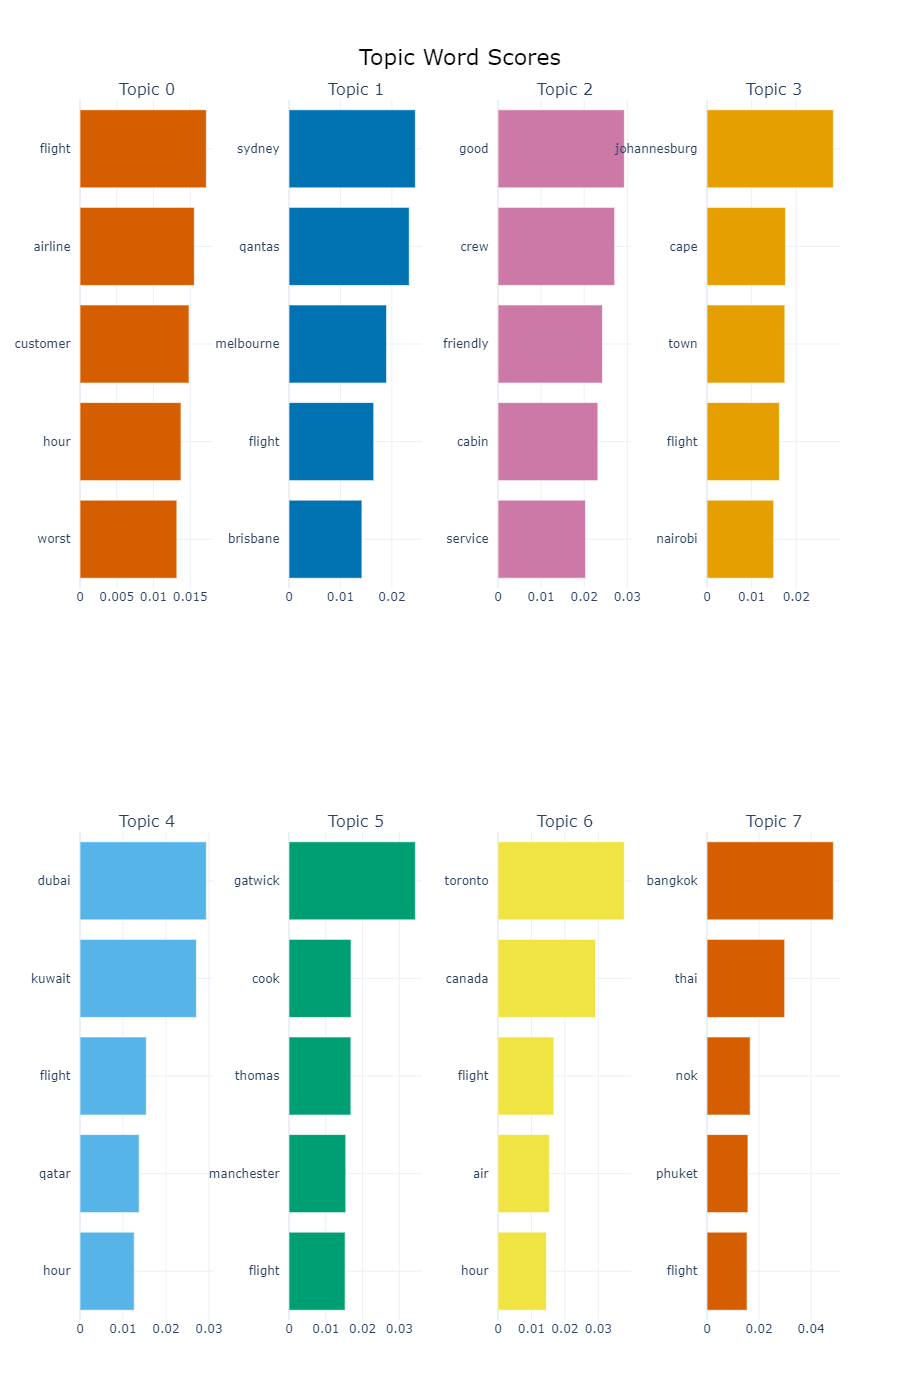

In [18]:
topic_model.visualize_barchart(top_n_topics=8, height=700)

<div class="alert alert-block alert-info"> ✅ <b>Note</b>: BERTopic package has a lot of built-in visualizations relevant to the topic modelling domain. They are impelemented on top of Plotly thus they have interactivity and other good capabilities / flavour of such a nice visualization library.</div>

For each topic, we have generated 10 words that best represent that topic. However, are 10 words sufficient? Can we already have a good topic representation with less number of representative words?

To understand the amount of words needed to have a sufficient topic representation, we can show the decline of term score when adding terms. The idea here is that each term that is added has a lower term score than the previous since the first is the best term for the topic. Eventually, we reach the point of diminishing returns, which is very similar to the elbow-method used in k-NN. Below, you can see the decline in term score when adding terms per topic:

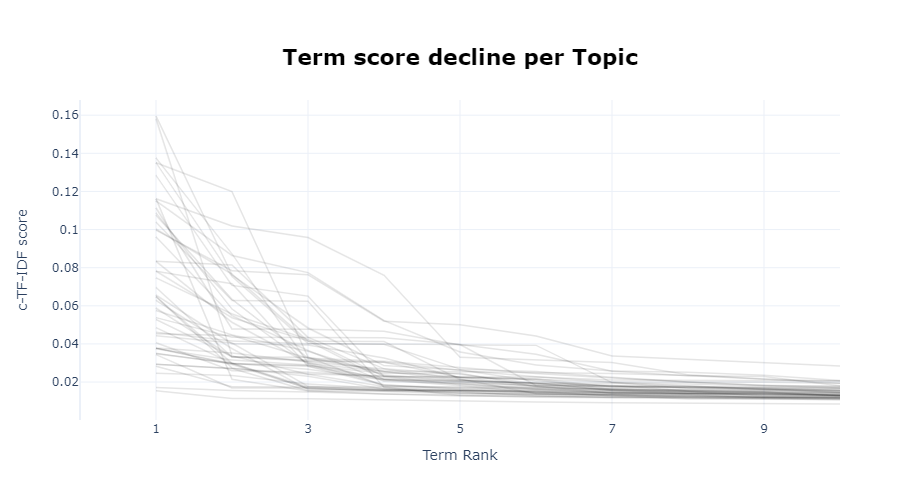

In [19]:
topic_model.visualize_term_rank()

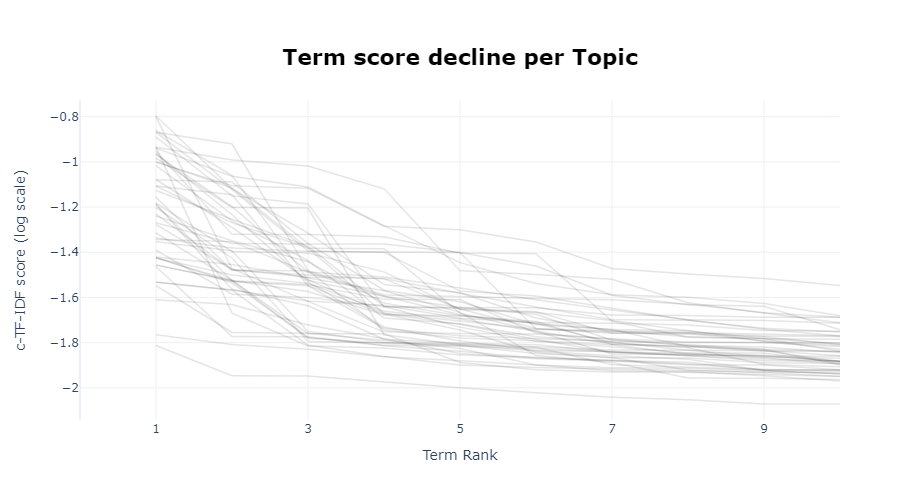

In [20]:
topic_model.visualize_term_rank(log_scale=True)

Using the elbow method, it seems that 3 words per topic are sufficient in representing the majority of the topics well. Some topics have variability (4 or 5 words per a topic to be representative).

Any words that we add after that have seemingly little effect.

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Distance Map Between Topics</div>

We embed our c-TF-IDF representation of the topics in 2D using UMAP.

We can then visualize the distance between topics that were generated in a way very similar to LDAvis package in R.

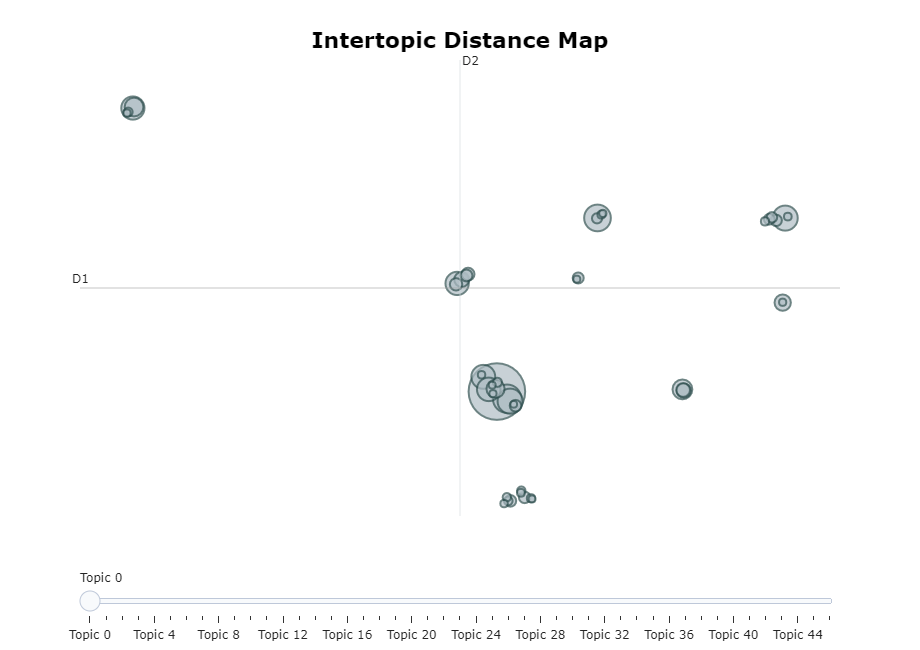

In [21]:
topic_model.visualize_topics(top_n_topics=50)



The distance between topics show, to a certain extend, the similarities between topics. 

You can use the slider (one of the nice built-in features of animated Plotly charts) to navigate to any of the topics to see both its key parameters (keywords, number of reviews included to the topic etc.) as well as its neighbour topics.

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Deeper Dive into Topic Similarity</div>

To better visualize and understand the similarity between topics, we can use two plots to gives us further insight into that. Namely, we are going to visualize the possible topic hierarchy and its similarity matrix.

100%|██████████| 46/46 [00:00<00:00, 108.82it/s]


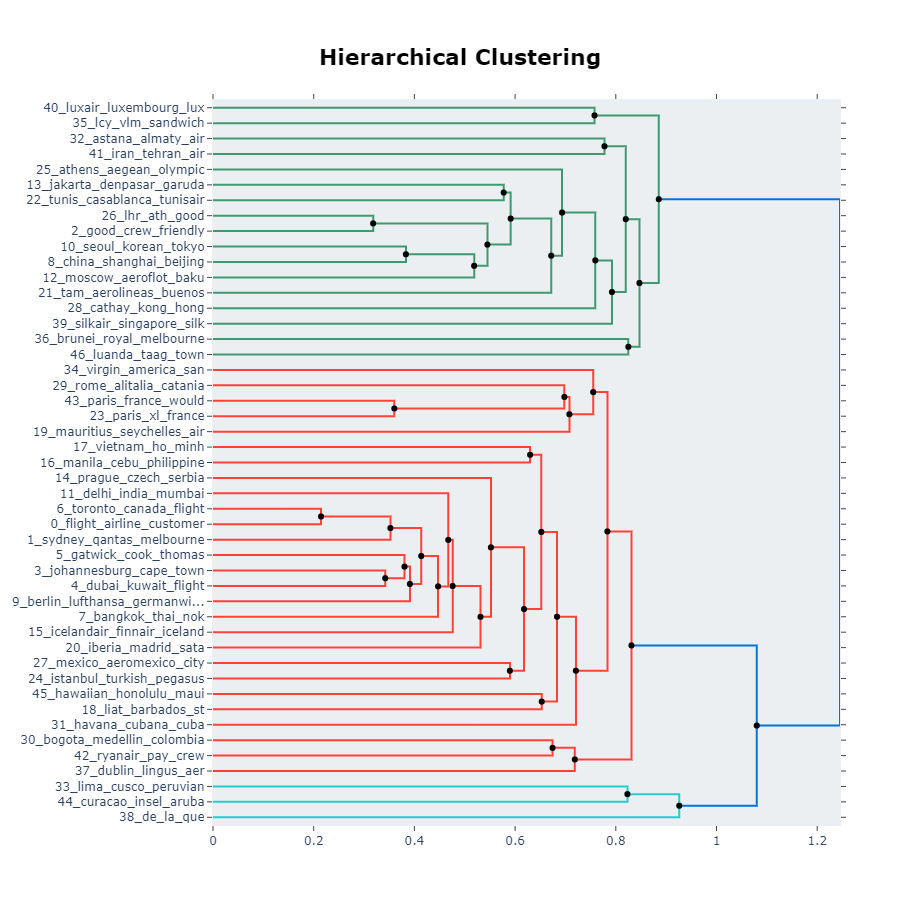

In [22]:
hierarchical_topics = topic_model.hierarchical_topics(docs)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

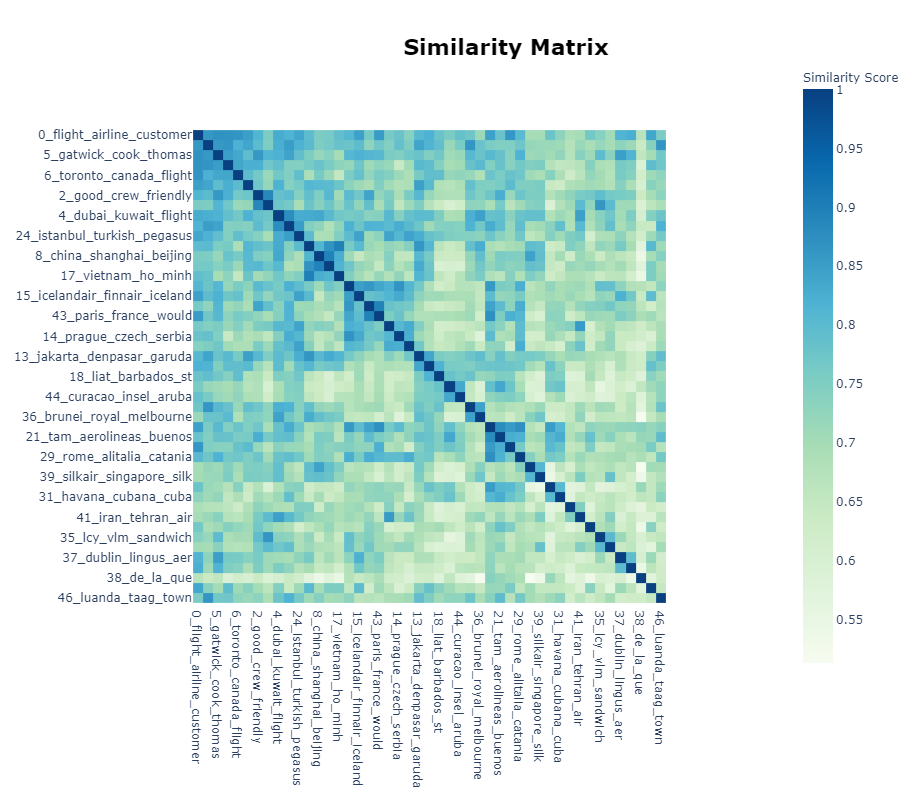

In [23]:
topic_model.visualize_heatmap(n_clusters=20, top_n_topics=100)

The blocky structure in the heatmap shows that there are some clusters of topics to be found that are somewhat similar to each other. Zooming into these topics helps us understand why they are similar. If you hover over the topics, you can see the topic ID and representation.

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Temporal View on Review Topics</div>

Although extracting the topics and their representation is interesting, we are missing some dimensional information. For example, some topics in the reviews might not be relevant anymore or some are gaining traction over the last years. That can be vital information when making decisions.

Here, we are going to see the evolution of the topics over the years.

In [24]:
# extract year from Review Date

topics_over_time = topic_model.topics_over_time(docs=docs, 
                                                timestamps=df['review_datetime'], 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=20)

20it [00:06,  2.94it/s]


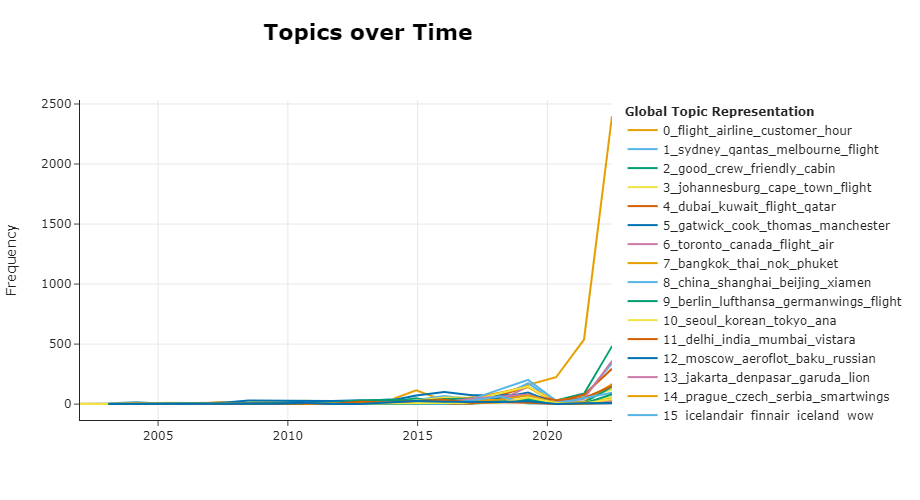

In [25]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20, width=900, height=500)

From the visualization above, we can see some interesting patterns appearing. Namely, a lot of topics seem to become less and less frequent around 2020 (and it can correlate with the generic airflight decline amid the global COVID-19-driven lockdowns). 

In 2022, with the lockdowns to be over, several topics take over again in term of the number of reviews/topic vibrancy. 

For example, topics 0 and 1 seem to be popular again in 2022-2023.

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Review Topics By Types of Traveller</div>

In [29]:
df_docs = df_docs.rename(columns={"Document": "Review", "Name": "Topic_Name"})
df = pd.merge(
    df,
    df_docs,
    how="inner",
    on='Review')

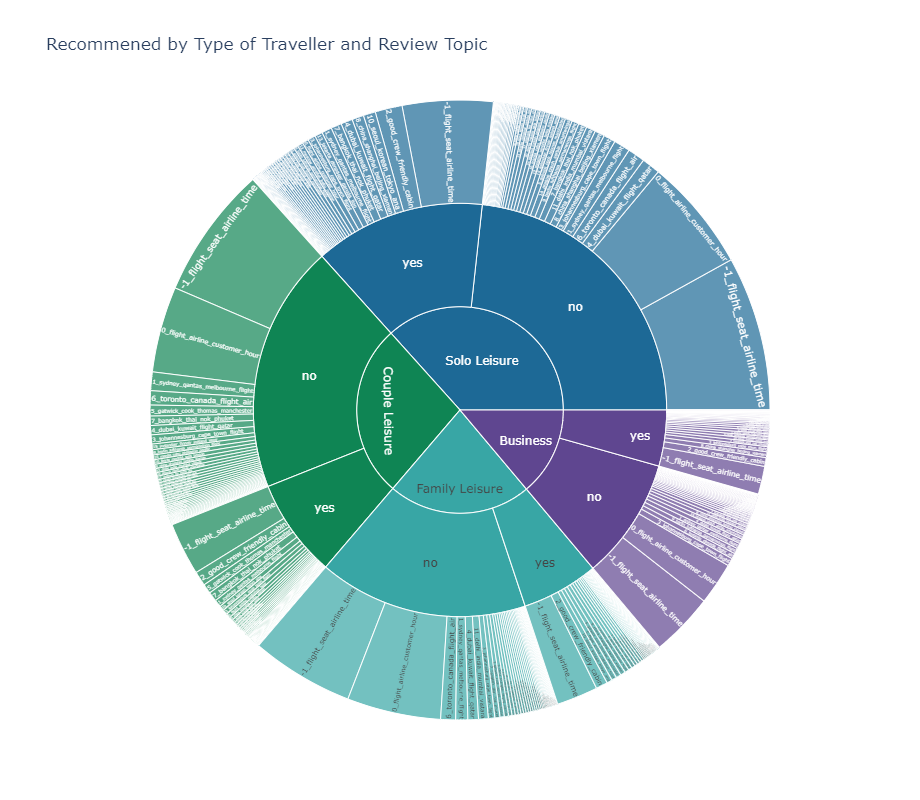

In [31]:
agg_data = df[["Type Of Traveller", "Recommended", "Topic_Name"]].groupby(["Type Of Traveller", "Recommended", "Topic_Name"]).size().reset_index(name="Count")
# define figure element
fig = px.sunburst(
    agg_data,
    values='Count',
    path=["Type Of Traveller",   "Recommended", "Topic_Name"],
    title="Recommened by Type of Traveller and Review Topic",
    color="Type Of Traveller",
    height=800,
    color_discrete_sequence=px.colors.qualitative.Prism,
    #color_continuous_scale=px.colors.sequential.Viridis
)
# display the figure
fig.show()

We can notice that the most of the reviews with *Recommended = 'no'* belongs to topic 0, across all of the types of travellers:

In [32]:
topic_model.get_topic(0)

[('flight', 0.01719325113480973),
 ('airline', 0.015559269147824982),
 ('customer', 0.014834512284733526),
 ('hour', 0.01374232654601149),
 ('worst', 0.01318184440175137),
 ('get', 0.012619554725245048),
 ('never', 0.01227199015137891),
 ('time', 0.012220292909752824),
 ('refund', 0.011912288223209746),
 ('service', 0.011507040058039692)]

In turn, the most of the reviews with *Recommended = 'yes'* belongs to topic 2, across all of the types of travellers:

In [33]:
topic_model.get_topic(2)

[('good', 0.029318651073004052),
 ('crew', 0.027079546131589246),
 ('friendly', 0.02424610529060904),
 ('cabin', 0.023174574751810614),
 ('service', 0.020304552294582508),
 ('food', 0.01946522524362311),
 ('flight', 0.019322313612949116),
 ('staff', 0.01898730019445349),
 ('great', 0.017958498270828106),
 ('comfortable', 0.017805836727681906)]

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Review Topics for Leading Airlines</div>

Extensive [EDA](https://www.kaggle.com/code/gvyshnya/airline-reviews-sentiments-ts-and-eda) identified three leading airlines, in terms of the best combination of the average *Overall_Rating* and *Value For Money*. These are

- China Southern Airlines
- Mahan Air 
- Royal Brunei Airlines

Let's look at the topics where the reviews for such airlines are represented.

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Guangzhou Pearl: China Southern Airlines</div>

Let's analize the review topic for Guangzhou-based *China Southern Airlines*.

In [37]:
airline_name = 'China Southern Airlines'
df_air = df[df["Airline Name"] == airline_name]

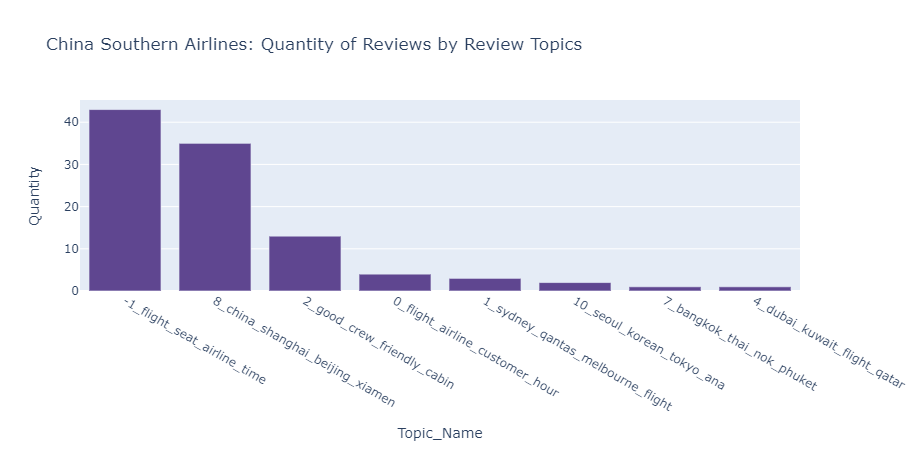

In [38]:
fig_title = ''.join([airline_name, ': Quantity of Reviews by Review Topics'])

dfg = df_air['Topic_Name'].value_counts().reset_index()
dfg.columns = ['Topic_Name', 'Quantity']
fig = px.bar(dfg, x='Topic_Name', y='Quantity', 
             title=fig_title,
            color_discrete_sequence=px.colors.qualitative.Prism) 
fig.show()

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Tehran-Based Service Leader: Mahan Air</div>

In [39]:
airline_name = 'Mahan Air'
df_air = df[df["Airline Name"] == airline_name]

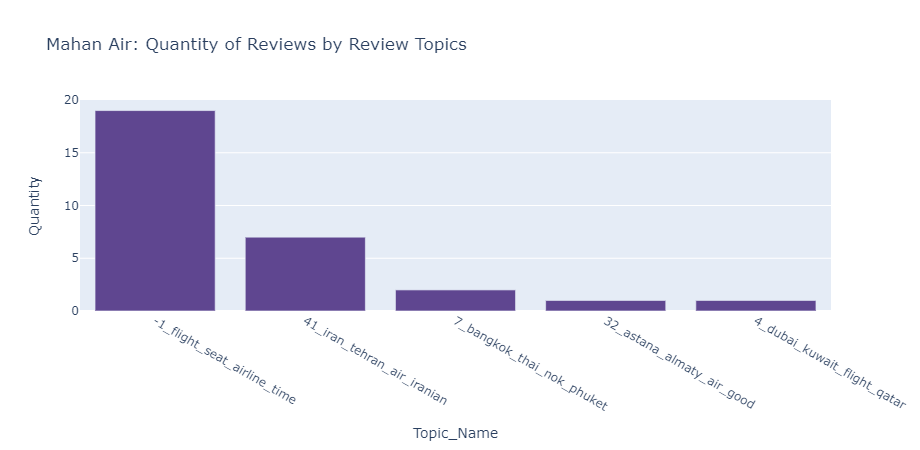

In [40]:
fig_title = ''.join([airline_name, ': Quantity of Reviews by Review Topics'])

dfg = df_air['Topic_Name'].value_counts().reset_index()
dfg.columns = ['Topic_Name', 'Quantity']
fig = px.bar(dfg, x='Topic_Name', y='Quantity', 
             title=fig_title,
            color_discrete_sequence=px.colors.qualitative.Prism) 
fig.show()

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Royal Brunei Airlines</div>

In [41]:
airline_name = 'Royal Brunei Airlines'
df_air = df[df["Airline Name"] == airline_name]

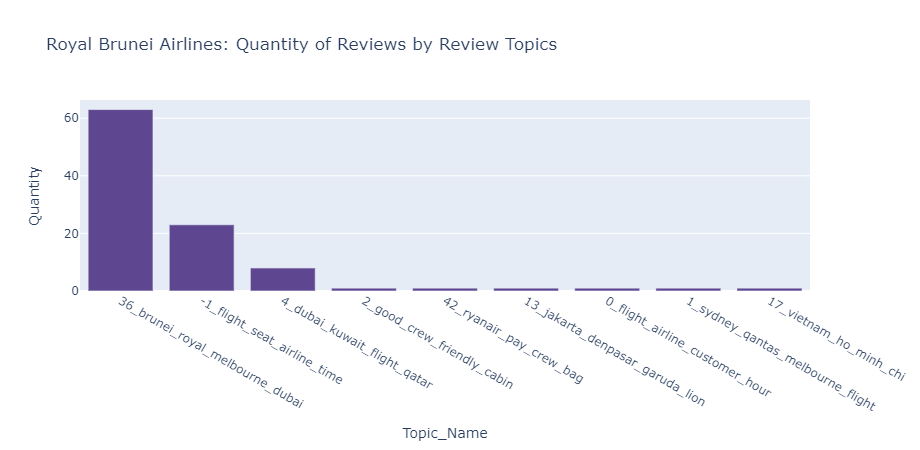

In [42]:
fig_title = ''.join([airline_name, ': Quantity of Reviews by Review Topics'])

dfg = df_air['Topic_Name'].value_counts().reset_index()
dfg.columns = ['Topic_Name', 'Quantity']
fig = px.bar(dfg, x='Topic_Name', y='Quantity', 
             title=fig_title,
            color_discrete_sequence=px.colors.qualitative.Prism) 
fig.show()

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">References</div>

The analysis flow inspired by https://www.kaggle.com/code/maartengr/topic-modeling-arxiv-abstract-with-bertopic/

